In [1]:
!pip install transformers[torch] datasets -q

In [2]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import json
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
json_file_path = 'Q_A.json'

with open(json_file_path, 'r') as file:
    dataset = json.load(file)


In [32]:
def load_image(image_path, base_path=f'C:/Users/faara/MYWork/My_Portfolio_Website/LLaVAData/BLIP Files/images'):
    full_path = os.path.join(base_path, image_path)
    image = Image.open(full_path).convert('RGB')  # Ensure RGB format
    return image


In [33]:
df = pd.read_json(json_file_path)
print(df.head())


                                         instruction  \
0  What operations were mentioned in last week's ...   
1         What was the focus of last week's lecture?   
2  What did last week's lecture mention about noi...   
3   What topics were covered in last week's lecture?   
4  What are some possible reasons for noise in im...   

                                            response                category  \
0  Last week's lecture mentioned operations such ...  information_extraction   
1  The focus of last week's lecture was on discus...               closed_qa   
2  Last week's lecture briefly mentioned the pres...               closed_qa   
3  Last week's lecture covered image representati...              general_qa   
4  Possible reasons for noise in images include l...  information_extraction   

   week  page                                            context  
0     3     2  The transcript discusses the operations covere...  
1     3     2  The transcript provides informati

## Sample Visualization

In [50]:
def construct_image_path(sample, base_path=f'C:/Users/faara/MYWork/My_Portfolio_Website/LLaVAData/BLIP_Files/images'):
    # image_file_name = f"week_{str(sample['week']).zfill(2)}_page_{str(sample['page']).zfill(3)}.png"

    image_file_name = f"/week_{sample['week']:02d}/week_{sample['week']:02d}_page_{sample['page']:03d}.png"
    print(base_path+image_file_name)
    return base_path+image_file_name


In [51]:

sample_index = 1
sample = dataset[sample_index]

image_path = construct_image_path(sample)
print(image_path)
image = Image.open(image_path).convert('RGB')

plt.imshow(image)
plt.axis('off')  
plt.show()
print("Question: {}".format(sample['instruction']))  
print("Answer: {}".format(sample['response']))  


C:/Users/faara/MYWork/My_Portfolio_Website/LLaVAData/BLIP Files/images/week_03/week_03_page_002.png
C:/Users/faara/MYWork/My_Portfolio_Website/LLaVAData/BLIP Files/images/week_03/week_03_page_002.png


: 

In [53]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

In [54]:
custom_dataset = CustomVQADataset(dataset)

train_data = custom_dataset.select(range(1400))  
val_data = custom_dataset.select(range(1400, len(custom_dataset))) 

## Build Data-loader

In [61]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, text_processor, image_processor):
        self.data = data
        self.instructions = data['instruction']
        self.responses = data['response']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128
        

        self.image_paths = [self.construct_image_path(row) for index, row in data.iterrows()]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instruction = self.instructions[idx]
        response = self.responses[idx]
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height, self.image_width),
                                  return_tensors="pt")

        text_encoding = self.text_processor(
                                  None,
                                  instruction,
                                  padding="max_length",
                                  truncation=True,
                                  max_length=self.max_length,
                                  return_tensors="pt"
                                  )
        

        for k, v in text_encoding.items():
            text_encoding[k] = v.squeeze()
        text_encoding["pixel_values"] = image_encoding["pixel_values"][0]
        
        # Add labels
        labels = self.text_processor.tokenizer.encode(
            response,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        text_encoding["labels"] = labels

        return text_encoding

    def construct_image_path(self, sample):
        base_path = '/kaggle/input/vqa-data/All_slides'

        image_file_name = f"week_{str(sample['week']).zfill(2)}_page_{str(sample['page']).zfill(3)}.png"

        return os.path.join(base_path, image_file_name)


In [56]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [62]:
train_df = pd.DataFrame(train_data.data)
val_df = pd.DataFrame(val_data.data)

train_vqa_dataset = VQADataset(data=train_df,
                               text_processor=text_processor,
                               image_processor=image_processor)

val_vqa_dataset = VQADataset(data=val_df,
                             text_processor=text_processor,
                             image_processor=image_processor)


In [63]:
train_vqa_dataset[0]

{'input_ids': tensor([ 101, 2054, 2515, 1996, 4955, 3104, 1999, 2023, 8835, 1029,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         ...,
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
         [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

        [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
         ...,
     

In [64]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [65]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


## Build Model

In [66]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [67]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] are there any further questions allowed after the introduction? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] yes, after the introduction, there is an opportunity for students to ask further questions. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


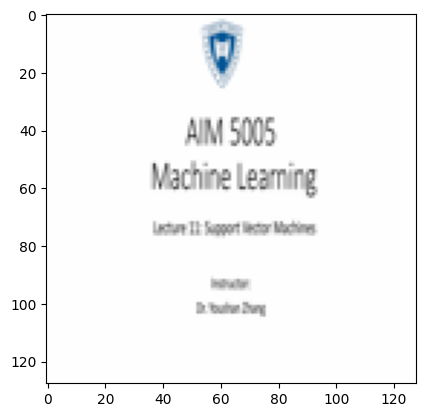

In [68]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

## Model Training

In [70]:
model.train()
for epoch in range(10):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 89.03863286972046
Epoch: 1


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 85.29268169403076
Epoch: 2


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 81.6833028793335
Epoch: 3


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 77.5846176147461
Epoch: 4


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 74.3389458656311
Epoch: 5


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 72.30945873260498
Epoch: 6


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 69.52040219306946
Epoch: 7


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 66.51643633842468
Epoch: 8


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 63.7185492515564
Epoch: 9


  0%|          | 0/22 [00:00<?, ?it/s]

Loss: 61.477657318115234


## Inference

Question:  how does stacking's sequential process contribute to its effectiveness?


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  the process of boosting is particularly effective in the meta - learner because it is trained on
Actual Answer:  stacking's sequential process contributes to its effectiveness by building a layered learning system. each layer, or base model, provides predictions that are used as


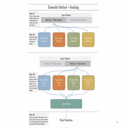

###################################################################
Question:  what is the impact of using diverse learning algorithms as base models in stacking?
Predicted Answer:  the use of boosting is significant in the boosting method because it allows for the combination of
Actual Answer:  using diverse learning algorithms as base models in stacking has a significant impact on the ensemble's performance. it allows the stacking method to capture a


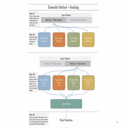

###################################################################
Question:  can you summarize the distinctions between bagging, boosting, and stacking?
Predicted Answer:  the boosting method is particularly effective in boosting as it allows for the method of using multiple
Actual Answer:  bagging involves training homogeneous models on different subsets of data in parallel, reducing variance through majority voting. boosting focuses on sequentially training weighted models


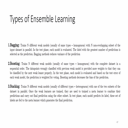

###################################################################
Question:  how does bagging reduce the variance of predictions?
Predicted Answer:  the bagging method is particularly useful in boosting as it allows for the use of multiple class
Actual Answer:  bagging reduces the variance of predictions by training multiple homogeneous models on different, non - overlapping subsets of the input data in parallel. the final prediction


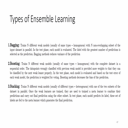

###################################################################
Question:  what is the focus of boosting in ensemble methods?
Predicted Answer:  the boosting method is an important method in boosting because it is a method that is efficient
Actual Answer:  the focus of boosting in ensemble methods is on sequentially training a series of weighted models on the complete dataset, where each model aims to correct


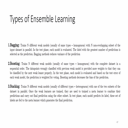

###################################################################
Question:  how does stacking's use of a meta - learner contribute to its effectiveness?
Predicted Answer:  the use of the meta - learner is crucial in the boosting process because it allows the
Actual Answer:  in stacking, the use of a meta - learner contributes to its effectiveness by learning the best way to blend the predictions of diverse base models.


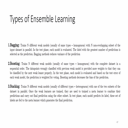

###################################################################
Question:  why is understanding the strengths of each ensemble method important?
Predicted Answer:  the significance of boosting is significant for the ensemble of boosting, as it allows for the
Actual Answer:  understanding the strengths of each ensemble methoda€ ” bagging's variance reduction, boosting's bias reduction, and stacking's model


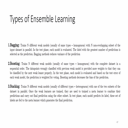

###################################################################
Question:  what is the primary objective of boosting in ensemble learning?
Predicted Answer:  the boosting method is considered a crucial method in boosting because it allows for the improvement of
Actual Answer:  the primary objective of boosting in ensemble learning is to reduce the bias of the final prediction. it achieves this by sequentially training models to focus


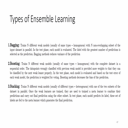

###################################################################
Question:  in what way does stacking maximize predictive strength?
Predicted Answer:  the boosting method is particularly effective in boosting as it allows the meta - learner to
Actual Answer:  stacking maximizes predictive strength by layering diverse models and using a meta - learner to integrate their predictions. this layering allows stacking


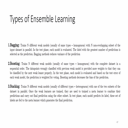

###################################################################
Question:  how does the layering of models in stacking differ from other ensemble methods?
Predicted Answer:  the process of boosting is particularly effective in the meta - learner because it allows the model
Actual Answer:  the layering of models in stacking differs from other ensemble methods in its approach to combining model predictions. unlike bagging's parallel model aggregation or


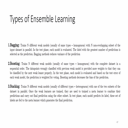

###################################################################
Question:  what advantages does stacking offer in complex problem - solving scenarios?
Predicted Answer:  the use of boosting is crucial in the boosting method because it allows for the combination of
Actual Answer:  in complex problem - solving scenarios, stacking offers the advantage of effectively combining diverse perspectives and strengths of various models. by using a meta - learner


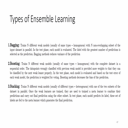

###################################################################
Question:  why is reducing bias a key aspect of boosting in ensemble learning?
Predicted Answer:  boosting is particularly effective in boosting as it is crucial for those that are complex or are
Actual Answer:  reducing bias is a key aspect of boosting in ensemble learning because bias can lead to systematic errors and inaccuracies in predictions. boosting addresses


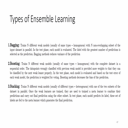

###################################################################
Question:  what is the primary objective of using bagging in ensemble learning?
Predicted Answer:  the primary purpose of using bagging in boosting is to create multiple models, including machine learning
Actual Answer:  the primary objective of using bagging in ensemble learning is to reduce the variance in predictions by leveraging the collective insights of multiple models trained on diverse subset


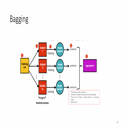

###################################################################
Question:  how are training subsets created for models in the bagging technique?
Predicted Answer:  training classifiers on boosting is important because it allows for a flexible and efficient process of training
Actual Answer:  training subsets for models in the bagging technique are created by randomly sampling the original dataset with replacement, known as bootstrapping, which results


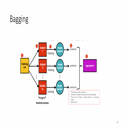

###################################################################
Question:  what mechanism is typically used to aggregate predictions in bagging?
Predicted Answer:  the boosting process is particularly effective in the context of boosting as it allows for the creation
Actual Answer:  in bagging, predictions from all models are typically aggregated through a majority vote mechanism for classification tasks or averaging for regression tasks, to produce the final


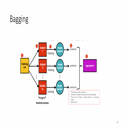

###################################################################
Question:  how does bagging differ from other ensemble methods like boosting and stacking?
Predicted Answer:  boosting is particularly effective in boosting as it allows for a diverse set of training methods,
Actual Answer:  bagging differs from other ensemble methods like boosting and stacking by training models in parallel on bootstrapped subsets of data and aggregating


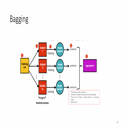

###################################################################
Question:  what role do weak learners play in the bagging methodology?
Predicted Answer:  in boosting, the weak - attention layer plays a crucial role in handling the model's
Actual Answer:  in the bagging methodology, weak learners refer to the individual models trained on bootstrapped subsets of the dataset. despite being'weak,


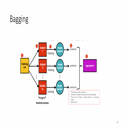

###################################################################
Question:  why is parallel model training emphasized in bagging?
Predicted Answer:  the process of training an encoder in bagging is crucial for the model's processing
Actual Answer:  parallel model training is emphasized in bagging to ensure that each model learns independently from its bootstrapped subset, enhancing the diversity of the learning process and


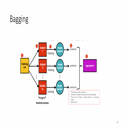

###################################################################
Question:  how does the final decision - making process work in bagging?
Predicted Answer:  the final stage of the bagging process is crucial for the final project as it is trained on
Actual Answer:  the final decision - making process in bagging works by aggregating the individual predictions of all the trained models, either through voting or averaging, depending


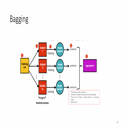

###################################################################
Question:  what are the benefits of using bootstrapped subsets of data in bagging?
Predicted Answer:  the use of bootstrap sampling in bagging is significant as it helps in mitigating
Actual Answer:  using bootstrapped subsets of data in bagging introduces variability and diversity in the training process for each model, enabling the ensemble to cover a broader


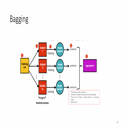

###################################################################
Question:  in what scenarios is bagging particularly effective, and why?
Predicted Answer:  bagging is particularly effective in boosting as it helps in mitigating the model's
Actual Answer:  bagging is particularly effective in scenarios prone to high variance and overfitting, such as with complex models on small datasets. by aggre


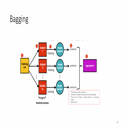

###################################################################
Question:  how can the effectiveness of a bagging ensemble be evaluated?
Predicted Answer:  the use of bagging in boosting is significant as it allows for a flexible and efficient method
Actual Answer:  the effectiveness of a bagging ensemble can be evaluated by comparing its predictive performance, such as accuracy or mean squared error, against individual models or other


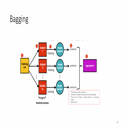

###################################################################
Question:  what is the initial step in the stacking ensemble method?
Predicted Answer:  the process of boosting is crucial in the boosting process because it is trained on the previous
Actual Answer:  the initial step in the stacking ensemble method involves training multiple distinct modelsa€ ” model 1, model 2, model 3, etc. a€


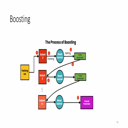

###################################################################
Question:  how are the outputs of the base models used in stacking?
Predicted Answer:  in the boosting process, the meta - learner, or stacking process, such as
Actual Answer:  in stacking, the outputs or predictions of the base models are combined to form a new training dataset. this dataset captures the various models '


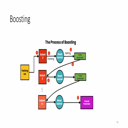

###################################################################
Question:  what role does the meta - model play in stacking?
Predicted Answer:  the attention mechanism's method to boosting is crucial in the meta - learner because it
Actual Answer:  the meta - model in stacking interprets the base models'predictions and makes the final prediction. it learns the best way to combine the base models


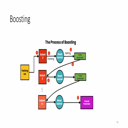

###################################################################
Question:  why is stacking considered effective for enhancing prediction accuracy?
Predicted Answer:  the boosting method is a method that is trained on the base of the input sequence, as
Actual Answer:  stacking is considered effective for enhancing prediction accuracy because it blends the strengths of various models through a meta - model. this layered approach allows for a


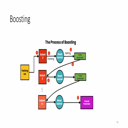

###################################################################
Question:  how does stacking differ from other ensemble methods like bagging and boosting?
Predicted Answer:  boosting is particularly effective in the context of multiple classifiers because it allows for the use of
Actual Answer:  stacking differs from other ensemble methods like bagging and boosting by employing a meta - model that learns how to optimally combine the predictions of base


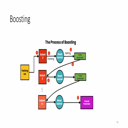

###################################################################
Question:  what is the key to successful stacking in ensemble learning?
Predicted Answer:  the use of boosting is significant in the boosting method because it allows for the method of
Actual Answer:  the key to successful stacking in ensemble learning lies in creating and training an effective meta - model, which can accurately learn the best way to integrate the


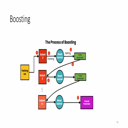

###################################################################
Question:  how does the meta - model improve the ensemble's predictive performance?
Predicted Answer:  the attention mechanism's approach to boosting is crucial in its approach to boosting, as
Actual Answer:  the meta - model improves the ensemble's predictive performance by accurately interpreting the combined outputs of the base models, effectively determining the most reliable predictions and


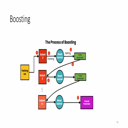

###################################################################
Question:  what distinguishes the dataset used to train the meta - model in stacking?
Predicted Answer:  the boosting method is particularly useful in the boosting method because it allows the model to process
Actual Answer:  the dataset used to train the meta - model in stacking is distinguished by its composition, which includes the predictions of the base models as features,


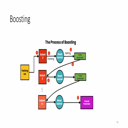

###################################################################
Question:  why might stacking be preferred over single - model approaches?
Predicted Answer:  the boosting method is a method that is trained on multiple datasets or classifiers,
Actual Answer:  stacking might be preferred over single - model approaches due to its ability to capture and leverage the predictive strengths of multiple models, thereby reducing bias and


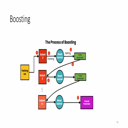

###################################################################
Question:  how can the effectiveness of a stacking ensemble be assessed?
Predicted Answer:  the use of boosting is crucial in the boosting method because it allows for the combination of
Actual Answer:  the effectiveness of a stacking ensemble can be assessed by evaluating the accuracy, precision, recall, or other relevant metrics of the final predictions made by


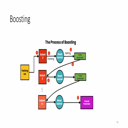

###################################################################
Question:  what distinguishes stacking from other ensemble methods such as bagging and boosting?
Predicted Answer:  boosting is considered a crucial method for boosting because it is particularly effective in scenarios where multiple
Actual Answer:  stacking is distinguished from other ensemble methods like bagging and boosting by its layered approach, which utilizes a meta - model at its core to integrate


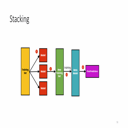

###################################################################
Question:  how does the meta - model contribute to the effectiveness of stacking?
Predicted Answer:  the boosting method is a method that is trained on the attention mechanism, primarily in its ability
Actual Answer:  the meta - model in stacking contributes to its effectiveness by learning how to best combine the predictions of various base models, thereby optimizing the final


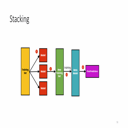

###################################################################
Question:  why is stacking considered a unique strategy for improving model performance?
Predicted Answer:  the use of boosting is significant as it allows the model to process and interpret complex data,
Actual Answer:  stacking is considered a unique strategy for improving model performance because it leverages the strengths of multiple predictive models through a second - level model, the


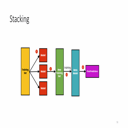

###################################################################
Question:  what is the core component of the stacking approach in ensemble learning?
Predicted Answer:  the purpose of boosting is to process multiple classifiers in an it, using the attention mechanism
Actual Answer:  the core component of the stacking approach in ensemble learning is the meta - model, which serves to interpret and integrate the outputs of the base models,


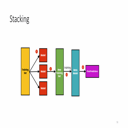

###################################################################
Question:  how does stacking enhance the predictive performance of models?
Predicted Answer:  boosting is particularly effective in the meta - learner because it is designed to process multiple class
Actual Answer:  stacking enhances the predictive performance of models by utilizing the meta - model to effectively learn from the diverse predictions of the base models, thus achieving


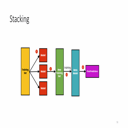

###################################################################
Question:  in what way does the layered approach of stacking improve upon bagging and boosting?
Predicted Answer:  the boosting method is particularly effective in the boosting process because it allows for the combination of
Actual Answer:  the layered approach of stacking improves upon bagging and boosting by adding an additional level of learning through the meta - model, which specifically focuses on


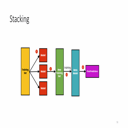

###################################################################
Question:  what makes the stacking method unique in the realm of ensemble learning?
Predicted Answer:  the process of boosting is particularly effective in the meta - learner because it is designed to
Actual Answer:  the stacking method is unique in the realm of ensemble learning due to its method of combining multiple models'predictions into a new dataset, which a


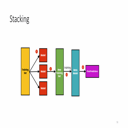

###################################################################
Question:  why might a data scientist choose stacking over bagging or boosting for a particular problem?
Predicted Answer:  the use of boosting as a method for boosting is significant as it allows for a flexible
Actual Answer:  a data scientist might choose stacking over bagging or boosting for a particular problem because stacking's ability to accurately blend multiple models'predictions


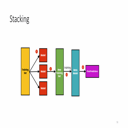

###################################################################
Question:  how does the integration of base models'predictions by a meta - model work in stacking?
Predicted Answer:  in the boosting process, the meta - learner uses multiple base - attention layers to process
Actual Answer:  in stacking, the integration of base models'predictions by a meta - model works by treating the base models'outputs as input features for the meta


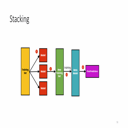

###################################################################
Question:  what challenges might arise when implementing the stacking method, and how can they be addressed?
Predicted Answer:  the use of boosting is significant as it helps in understanding the meta - learner's
Actual Answer:  challenges in implementing the stacking method might include the complexity of model selection and training for both base models and the meta - model, as well as the


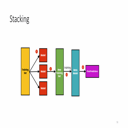

###################################################################
Question:  how does bagging contribute to reducing prediction variance?
Predicted Answer:  bagging is particularly effective in boosting as it helps in mitigating the errors of previous
Actual Answer:  bagging contributes to reducing prediction variance by employing a simple voting mechanism among homogeneous models trained on bootstrapped subsets of the dataset, effectively averaging


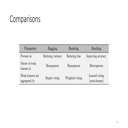

###################################################################
Question:  what distinguishes boosting's approach to improving model predictions?
Predicted Answer:  the boosting method is particularly effective in boosting because it is a crucial method that is efficient
Actual Answer:  boosting distinguishes itself by utilizing homogeneous models and a weighted voting system to sequentially correct errors in the models'predictions, specifically targeting and reducing bias to


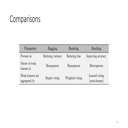

###################################################################
Question:  how does stacking's use of a meta - learner enhance model accuracy?
Predicted Answer:  the use of boosting is crucial in the meta - learner as it allows the model to
Actual Answer:  stacking enhances model accuracy through the use of a meta - learner, which is trained on the predictions of heterogeneous base models.


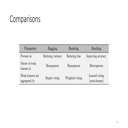

###################################################################
Question:  why is stacking considered unique among ensemble methods?
Predicted Answer:  the use of boosting is significant as it allows for the method of combining multiple classifiers in
Actual Answer:  stacking is considered unique among ensemble methods due to its integration of heterogeneous models and the use of a meta - learner for the final


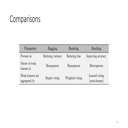

###################################################################
Question:  what are the core differences between bagging, boosting, and stacking?
Predicted Answer:  the boosting process is particularly effective in boosting as it allows for the creation of multiple class
Actual Answer:  the core differences among bagging, boosting, and stacking include bagging's focus on variance reduction through simple aggregation, boosting's


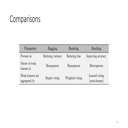

###################################################################
Question:  how do ensemble methods strategically apply in predictive modeling?
Predicted Answer:  boosting is considered an important method in boosting because it is crucial for the ensemble method to
Actual Answer:  ensemble methods are strategically applied in predictive modeling by leveraging their unique attributesa€ ” bagging for variance stabilization, boosting for bias minimi


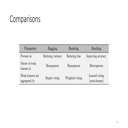

###################################################################
Question:  what makes a meta - learner essential in stacking's methodology?
Predicted Answer:  the boosting method is a method that is trained on the base of the attention mechanism. it
Actual Answer:  a meta - learner is essential in stacking's methodology because it synthesizes the predictions of the base models, learning the optimal way to


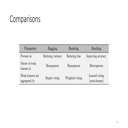

###################################################################
Question:  in what ways do bagging and boosting specifically target model improvements?
Predicted Answer:  the boosting method is particularly useful in boosting as it allows for the creation of multiple class
Actual Answer:  bagging and boosting target model improvements by focusing on different aspects of error reduction ; bagging aims to decrease variance without specifically targeting bias, while boost


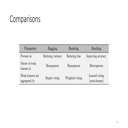

###################################################################
Question:  why might a data scientist choose one ensemble method over another?
Predicted Answer:  the attention mechanism is particularly effective in boosting as it allows for a more flexible and accurate approach
Actual Answer:  a data scientist might choose one ensemble method over another based on the specific challenges of the problem at hand, such as the need to reduce prediction variance (


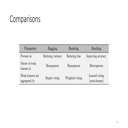

###################################################################
Question:  how does the layered approach in stacking compare to the sequential model correction in boosting?
Predicted Answer:  the boosting method is particularly effective in the boosting process because it is a method that is
Actual Answer:  the layered approach in stacking, with its focus on using a meta - learner, contrasts with boosting's sequential model correction by providing a


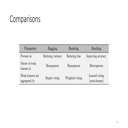

###################################################################
Question:  what type of resources are recommended for a deeper understanding of boosting techniques?
Predicted Answer:  boosting is considered a crucial method for boosting because it allows for the use of multiple class
Actual Answer:  for a deeper understanding of boosting techniques, specific scholarly articles, textbooks, or online tutorials that focus on ensemble methods and their applications in machine learning


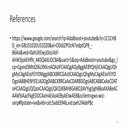

###################################################################
Question:  how can references enhance a learner's comprehension of boosting in machine learning?
Predicted Answer:  boosting is particularly effective in machine learning applications because it allows for some reasons, as it allows
Actual Answer:  references can enhance a learner's comprehension of boosting by providing detailed explanations, examples, and case studies that illustrate the theoretical concepts, practical implementations


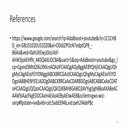

###################################################################
Question:  why might someone seek additional references for understanding boosting?
Predicted Answer:  the boosting process is particularly effective in boosting because it is particularly effective in certain ways because
Actual Answer:  someone might seek additional references for understanding boosting to gain a more comprehensive insight into the algorithm's intricacies, including its mathematical foundations, algorithm


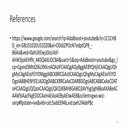

###################################################################
Question:  what kind of improvements can be achieved through a deeper study of boosting from recommended references?
Predicted Answer:  boosting is particularly effective in boosting as it allows for a more flexible and accurate approach to
Actual Answer:  through a deeper study of boosting from recommended references, improvements can be achieved in model accuracy, understanding of bias - variance trade - offs, and the


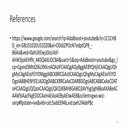

###################################################################
Question:  how do references contribute to the practical application of boosting in predictive modeling?
Predicted Answer:  boosting is particularly effective in boosting as it allows for the improvement of the boosting method
Actual Answer:  references contribute to the practical application of boosting in predictive modeling by offering insights into advanced techniques, parameter tuning, and strategies for overcoming common challenges,


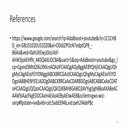

###################################################################
Question:  what is the primary objective of the final project involving ensemble methods?
Predicted Answer:  the process of boosting is crucial in the context of the final project because it allows for the
Actual Answer:  the primary objective of the final project is to construct a robust predictive model using the bagging ensemble technique with gradient boosting tree ( gbt )


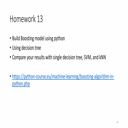

###################################################################
Question:  why are gradient boosting tree models chosen as base learners for the ensemble model?
Predicted Answer:  boosting is considered a crucial method for boosting because it is a technique used in the boost
Actual Answer:  gradient boosting tree models are chosen as base learners for the ensemble model due to their effectiveness in handling various types of data, capability to model complex relationships


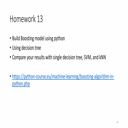

###################################################################
Question:  how will the performance of the ensemble model be evaluated in the final project?
Predicted Answer:  the performance of the attention mechanism in boosting is significant as it allows for a flexible and accurate
Actual Answer:  the performance of the ensemble model in the final project will be evaluated by benchmarking its predictive accuracy against standalone models, specifically a single instance each


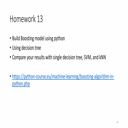

###################################################################
Question:  what insights are expected from comparing the bagging ensemble model with svm and knn?
Predicted Answer:  the significance of lecture or lecture boosting in bagging is to improve the overall accuracy of machine
Actual Answer:  comparing the bagging ensemble model with svm and knn is expected to provide insights into the strengths and limitations of each modeling approach, highlighting the effectiveness


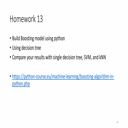

###################################################################
Question:  what practical skills are to be gained from undertaking the final project on ensemble methods?
Predicted Answer:  the process of boosting is considered exciting and effective in applications, as it allows for some additional
Actual Answer:  by undertaking the final project on ensemble methods, participants will gain hands - on experience in implementing ensemble methods, specifically bagging with gbt models, and


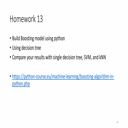

###################################################################
Question:  why is it important to compare the ensemble model's performance with standalone models like svm and knn?
Predicted Answer:  the significance of boosting in the boosting process is to improve its ability to process and process
Actual Answer:  it is important to compare the ensemble model's performance with standalone models like svm and knn to understand how ensemble methods like bagging with gb


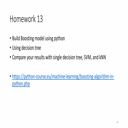

###################################################################
Question:  what challenges might arise in the implementation of the bagging ensemble technique with gbts?
Predicted Answer:  challenges in boosting include increased computational, and increased model accuracy, as it allows for a more
Actual Answer:  challenges in implementing the bagging ensemble technique with gbts may include optimizing the number and depth of trees to prevent overfitting, efficiently managing


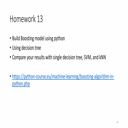

###################################################################
Question:  how does employing multiple instances of gbts as base learners benefit the ensemble model?
Predicted Answer:  boosting is considered a crucial method for multi - classifiers because it allows for the method of
Actual Answer:  employing multiple instances of gbts as base learners benefits the ensemble model by introducing a diverse set of predictions that account for various aspects and patterns within the data


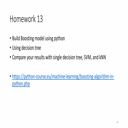

###################################################################
Question:  what key factors should be considered when training an ensemble of gbt models?
Predicted Answer:  the attention mechanism is particularly effective in boosting as it allows for some specific training tasks, as
Actual Answer:  when training an ensemble of gbt models, key factors to consider include the selection of loss functions, the learning rate to balance speed and accuracy of convergence


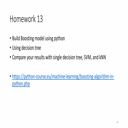

###################################################################
Question:  how will the project demonstrate the strategic value of ensemble methods in predictive modeling?
Predicted Answer:  the process of boosting is particularly effective in boosting applications because it allows for the method of
Actual Answer:  the project will demonstrate the strategic value of ensemble methods in predictive modeling by showcasing how the bagging technique, when applied with gbt models, can


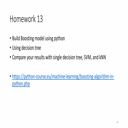

###################################################################
Question:  what is the primary goal of the final homework assignment involving boosting algorithms?
Predicted Answer:  the primary goal of boosting is to improve the model's accuracy by iteratively training
Actual Answer:  the primary goal of the final homework assignment is to utilize a specific boosting technique to enhance the predictive performance of a model, implementing a sequential training


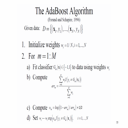

###################################################################
Question:  which boosting techniques might be focused on in the homework assignment?
Predicted Answer:  boosting is particularly effective in the boosting method because it allows for some reasons, like boost
Actual Answer:  the homework assignment might focus on implementing a variant of the boosting algorithm, such as adaboost or gradient boosting, each designed to sequentially


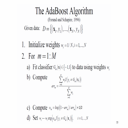

###################################################################
Question:  how does the boosting algorithm improve the ensemble model's predictive performance?
Predicted Answer:  the boosting process is particularly effective in boosting because it is a crucial method that is efficient
Actual Answer:  the boosting algorithm improves the ensemble model's predictive performance by sequentially training models to correct the errors made by previous models, using techniques like


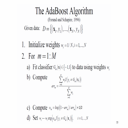

###################################################################
Question:  what principles from the lecture will guide the implementation of the boosting algorithm?
Predicted Answer:  the lecture is particularly effective in boosting as it allows for the boosting process to focus on
Actual Answer:  the implementation of the boosting algorithm will be guided by principles outlined in the lecture, including the importance of weighting errors and iteratively adjusting the


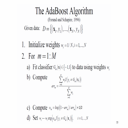

###################################################################
Question:  how will the homework project demonstrate the value added by boosting techniques?
Predicted Answer:  the boosting process is particularly effective in boosting because it allows for the use of multiple class
Actual Answer:  the homework project will demonstrate the value added by boosting techniques by comparing the outcomes of the boosted ensemble model to those of simpler, non - boosted models


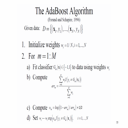

###################################################################
Question:  what challenges might students face when implementing boosting algorithms in their project?
Predicted Answer:  boosting is particularly effective in boosting as it allows for some specific tasks, as it helps
Actual Answer:  students might face challenges such as selecting the optimal parameters for the boosting algorithm, effectively handling overfitting due to the increased complexity of the model,


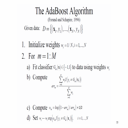

###################################################################
Question:  why is sequential training of models a key aspect of boosting algorithms?
Predicted Answer:  boosting is particularly effective in boosting as it is designed to process complex datasets,
Actual Answer:  sequential training of models is a key aspect of boosting algorithms because it allows each subsequent model to specifically address and correct the errors made by previous models,


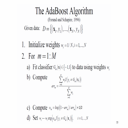

###################################################################
Question:  how do adaboost and gradient boosting differ in their approach to boosting?
Predicted Answer:  the boosting process is particularly effective in boosting because it is an itch based method that
Actual Answer:  adaboost and gradient boosting differ in their approach to boosting primarily in how they adjust the weights of incorrectly predicted instances and in their loss optimization


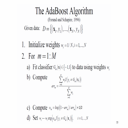

###################################################################
Question:  what role does error weighting play in the effectiveness of boosting algorithms?
Predicted Answer:  the boosting method is particularly effective in boosting as it allows for the loss of classifiers
Actual Answer:  error weighting plays a crucial role in the effectiveness of boosting algorithms by emphasizing the importance of correctly predicting instances that previous models misclassified. this


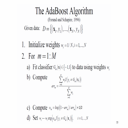

###################################################################
Question:  can you explain how ensemble methods like bagging and boosting differ in their approach to reducing model error?
Predicted Answer:  boosting is particularly effective in bagging as it allows for a diverse set of methods to process
Actual Answer:  ensemble methods like bagging and boosting differ in their approach to reducing model error by focusing on variance and bias, respectively. bagging reduces variance by


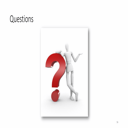

###################################################################
Question:  what are the practical considerations when implementing a stacking ensemble method?
Predicted Answer:  the use of boosting is crucial in the context of boosting as it allows the model to
Actual Answer:  practical considerations when implementing a stacking ensemble method include selecting diverse base models, training a meta - model to effectively combine their predictions, and addressing computational complexity


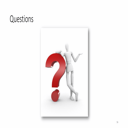

###################################################################
Question:  how do boosting algorithms adjust the weights of training instances?
Predicted Answer:  boosting is particularly effective in boosting as it allows for the boosting process, as it
Actual Answer:  boosting algorithms adjust the weights of training instances by increasing the weights of incorrectly predicted instances, ensuring that subsequent models focus more on these hard - to -


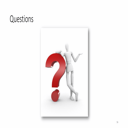

###################################################################
Question:  in what scenarios might a data scientist prefer using boosting over bagging?
Predicted Answer:  boosting is particularly effective in the context of boosting as it allows for a flexible and accurate
Actual Answer:  a data scientist might prefer using boosting over bagging in scenarios where model bias is a significant issue and where sequential learning from previous errors can lead to


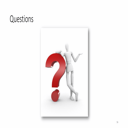

###################################################################
Question:  what challenges could arise from using a meta - learner in stacking, and how can they be mitigated?
Predicted Answer:  the use of boosting in boosting is significant as it allows the model to process and interpret
Actual Answer:  challenges with using a meta - learner in stacking include model selection complexity and risk of overfitting. these can be mitigated by careful


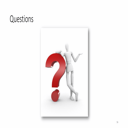

###################################################################
Question:  how can online students practically apply the concepts learned about ensemble methods?
Predicted Answer:  potential applications of attention boosting include increased accuracy in machine learning research, reducing overfitting,
Actual Answer:  online students can practically apply concepts learned about ensemble methods by engaging in hands - on projects or kaggle competitions, using datasets to implement and compare


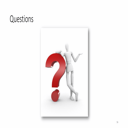

###################################################################
Question:  what are the key factors in choosing between adaboost and gradient boosting for a project?
Predicted Answer:  the use of the attention mechanism in boosting is significant as it allows for the method of using
Actual Answer:  key factors in choosing between adaboost and gradient boosting include the specific problem characteristics, such as the type of data and the nature of errors (


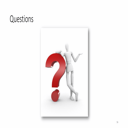

###################################################################
Question:  how does the concept of error weighting in boosting contribute to model improvement?
Predicted Answer:  the boosting method is particularly effective in boosting as it allows for the model's flexibility
Actual Answer:  error weighting in boosting contributes to model improvement by emphasizing learning from previous mistakes, allowing subsequent models to focus on harder cases, thus systematically reducing overall


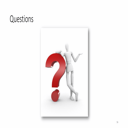

###################################################################
Question:  can ensemble methods be applied to any type of machine learning problem, or are there limitations?
Predicted Answer:  an attention mechanism is considered a key technique in machine learning because it allows for some ways of processing
Actual Answer:  ensemble methods can be applied to a wide range of machine learning problems, but their effectiveness may vary depending on the data complexity, problem type, and the


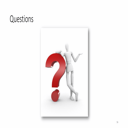

###################################################################
Question:  what resources would you recommend for online students to further explore ensemble methods?
Predicted Answer:  boosting is particularly effective in applications where students can learn from a wide array of data, making
Actual Answer:  for further exploration of ensemble methods, online students are recommended to consult academic papers, machine learning textbooks, reputable online courses, and participate in practical exercises


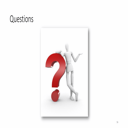

###################################################################
Question:  what is the deadline for submitting the final projects?
Predicted Answer:  the final project is considered a crucial foundation for students and those interested in boosting, as it
Actual Answer:  all final project submissions need to be completed and turned in by next friday, as mentioned in the session, to ensure the course stays on track with its


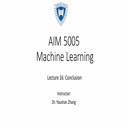

###################################################################
Question:  why is the final phase of the course considered crucial for students?
Predicted Answer:  the final project is considered a key process in boosting because it is important for the classifier
Actual Answer:  the final phase is crucial for students as it is a key opportunity to demonstrate their understanding and application of the concepts discussed throughout the course, marking the cu


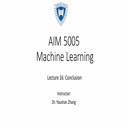

###################################################################
Question:  how will the final projects be reviewed, according to the session's transcript?
Predicted Answer:  the process of finalizing the final project, including several key components, is important for future research
Actual Answer:  the final projects will undergo a comprehensive review process that encapsulates everything learned throughout the course, as indicated in the session. this process aims to


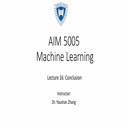

###################################################################
Question:  what is expected of students in their final project presentations?
Predicted Answer:  students interested in boosting are interested in these lecture, including research on support, research on research
Actual Answer:  in their final project presentations, students are expected to briefly showcase their projects, highlighting how they've applied the concepts learned throughout the course. this presentation


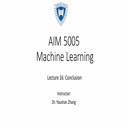

###################################################################
Question:  how does the timeline for project submission contribute to the course's curriculum?
Predicted Answer:  the process of course understanding is crucial for students and students in boosting because it allows for a
Actual Answer:  the timeline for project submission contributes to the course's curriculum by ensuring that all projects are submitted in a timely manner, allowing for a structured review and


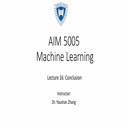

###################################################################
Question:  what are the key points students should grasp before proceeding to the final project presentations?
Predicted Answer:  the attention mechanism is particularly effective in boosting as it allows students to process their project, and
Actual Answer:  students should grasp the key concepts and methodologies discussed throughout the course, ensuring they can effectively apply these to their final projects and articulate their relevance and


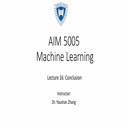

###################################################################
Question:  how does completing the final project on time impact the curriculum's integrity?
Predicted Answer:  the process of finalizing the final project, including several weeks in the development of machine learning,
Actual Answer:  completing the final project on time ensures the curriculum's integrity by adhering to the planned schedule, allowing for timely review and feedback, and maintaining the


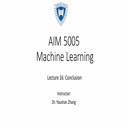

###################################################################
Question:  what measures can students take to ensure their projects encapsulate the course's learning?
Predicted Answer:  students can improve their skills in boosting, including creating multiple models, training large or scale models
Actual Answer:  students can review course materials, apply theoretical concepts to practical examples, seek feedback on preliminary work, and engage in peer discussions to ensure their projects fully en


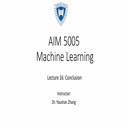

###################################################################
Question:  in what ways will the final presentations serve as a culmination of students'efforts?
Predicted Answer:  students are trained on their project and then project, as they prepare to process their project, they
Actual Answer:  the final presentations will serve as a culmination of students'efforts by providing a platform to showcase their comprehensive understanding, practical application of concepts, and


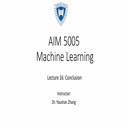

###################################################################
Question:  what challenges might students encounter during the final phase and how can they overcome them?
Predicted Answer:  challenges in boosting include increased computational, and reduced model accuracy, as it helps in smoothing out
Actual Answer:  students might encounter challenges such as time management, integrating complex concepts into their projects, and preparing for presentations. overcoming these challenges requires effective planning, utilizing course


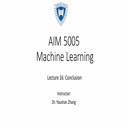

###################################################################
Question:  what topics are included in the course summary for the machine learning course?
Predicted Answer:  the process of training classifiers on the attention mechanism is crucial for those interested in machine learning,
Actual Answer:  the course summary for the machine learning course includes a review of what has been learned, discussions on the final project, final grade evaluations, and guidance


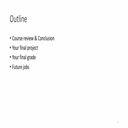

###################################################################
Question:  how does the course intend to guide students on applying machine learning knowledge to job opportunities?
Predicted Answer:  the process of using attention in machine learning research is crucial for students and their learning, as it
Actual Answer:  the course provides guidance on applying machine learning knowledge to job opportunities by discussing relevant skills, potential job roles, and the practical application of course learnings in


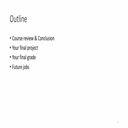

###################################################################
Question:  what is the significance of the final project in the context of the machine learning course?
Predicted Answer:  the process of boosting is crucial in machine learning as it allows for the creation of multiple class
Actual Answer:  the final project is significant as it serves as a practical application of the course's teachings, allowing students to demonstrate their understanding and ability to implement machine


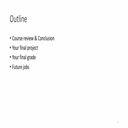

###################################################################
Question:  what considerations are involved in the final grading of the machine learning course?
Predicted Answer:  the process of boosting is crucial in machine learning as it allows for the processing of data and
Actual Answer:  final grading in the machine learning course involves considerations such as the quality and innovation demonstrated in the final project, mastery of course content, participation in discussions,


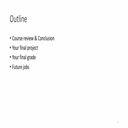

###################################################################


In [71]:
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=  ['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")